# experimets variability

I want to have a visual of the variability of the experiments

# setup

In [1]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path

In [2]:
FIGS_DIR = Path(".") / "figs"
FIGS_DIR.mkdir(exist_ok=True)

DATA_DIR = Path(".") / "data"
DATA_DIR.mkdir(exist_ok=True)

Let's first check that I have all the runs. 

## data

i create a link to where the data really is in a directory `data` parallel to the notebook

if things are moved away, make the link point to the right place

In [3]:
%pwd
%ls ../../data/results-snapshots-2/ | wc -l

'/home/jcasagrandebertoldo/repos/fcdd/python/analyse'

90


In [4]:
%mkdir -p data
%cd data
%rm results-snapshots-2
!ln -s ../../../data/results-snapshots-2/ 
%cd ..

/home/jcasagrandebertoldo/repos/fcdd/python/analyse/data
/home/jcasagrandebertoldo/repos/fcdd/python/analyse


In [5]:
%ls data/results-snapshots-2/ | wc -l

90


## funcs

In [6]:
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
from datetime import timedelta, datetime
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
import copy
from typing import List


# this is to get the strings associated to the classes in the fcdd code
# copied from: fcdd/python/fcdd/datasets/__init__.py
# inside function `str_labels`
# commit: 9f268d8fd2fee33a5c5f38cdfb781da927bdb614
CLASS_LABELS = {
    'cifar10': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    'fmnist': [
        't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ],
    'mvtec': [
        'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
        'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor',
        'wood', 'zipper'
    ],
    # 'imagenet': deepcopy(ADImageNet.ad_classes),
    # this one forwards to: fcdd/python/fcdd/datasets/imagenet.py
    # in: ADImageNet.ad_classes
    # at the same commit as above
    'imagenet': ['acorn', 'airliner', 'ambulance', 'American alligator', 'banjo', 'barn', 'bikini', 'digital clock',
                  'dragonfly', 'dumbbell', 'forklift', 'goblet', 'grand piano', 'hotdog', 'hourglass', 'manhole cover',
                  'mosque', 'nail', 'parking meter', 'pillow', 'revolver', 'dial telephone', 'schooner',
                  'snowmobile', 'soccer ball', 'stingray', 'strawberry', 'tank', 'toaster', 'volcano'],
    'pascalvoc': ['horse'],
}


def get_classes_labels_order(dataset: str) -> List[str]:
    return copy.deepcopy(CLASS_LABELS[dataset])


def get_class_label(class_dirname: str, dataset: str) -> str:
    return CLASS_LABELS[dataset][int(class_dirname.lstrip("normal_"))]


class MissingFileInExperiment(FileNotFoundError):
    pass


class UnfinishedExperiment(Exception):
    pass


def get_training_time(path: Path) -> Dict[str, float]:
    """
    The is printed in `log.txt` as 
        START: 21-12-2021 22:46:18 
        DURATION: 1:13:29.009893 
    so this function parses that file.
    
    :param path: points to the 'log.txt' file inside an experiment (dataset + class + iteration)
    
    # simple test
    TEST_PATH = Path("../../data/results/mvtec/supervised_merged/normal_0/it_0/log.txt")
    get_training_time(TEST_PATH)
    del TEST_PATH
    """
    DURATION_LINE_REGEX = r"^DURATION: (.+) $"
    DELTA_DATETIME_FORMAT = "%H:%M:%S.%f"
        
    try:
        # src: https://stackoverflow.com/a/1327389/9582881
        search = re.search(DURATION_LINE_REGEX, path.read_text(), re.MULTILINE)
    except Exception as ex:
        raise MissingFileInExperiment(ex)
        
    assert search is not None
    delta_str = search.group(1)
    assert delta_str != ""
    # src: https://stackoverflow.com/a/12352624/9582881
    t = datetime.strptime(delta_str, DELTA_DATETIME_FORMAT)
    delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
    assert delta > timedelta(0)
    return {"training_timedelta": delta}


def get_roc(path: Path) -> Dict[str, Union[float, ndarray]]:
    """
    :param path: points to the 'roc.json' file inside an experiment (dataset + class + iteration)
    """
    ROC_JSON_EXPECTED_KEYS = {"tpr", "fpr", "ths", "auc"}
    ROC_JSON_LISTS = {"tpr", "fpr", "ths"}
    
    try:
        with path.open("r") as json_file:
            payload = json.load(json_file)
    except FileNotFoundError as ex:
        raise MissingFileInExperiment(ex)
    
    assert type(payload) == dict, f"{type(payload)=}"
    assert set(payload.keys()) == ROC_JSON_EXPECTED_KEYS, f"{set(payload.keys())=}"
    
    # transform the lists in ndarrays
    for list_key in ROC_JSON_LISTS:
        list_obj = payload[list_key]
        assert type(list_obj) == list, f"{type(list_obj)=}"
        payload[list_key] = np.array(list_obj)
        
    return payload


def get_pixelwise_rocs_from_logtxt(path: Path) -> Dict[str, List[float]]:
    """
    The pixel-wise roc is often lost in mvtec because the images are big so the json
    with all the tpr/fpr/ths would be too big (there's a limit of 10MB somewhere in the code)
    but the pixel-wise ROC-AUC is printed in `log.txt` as like
    ##### GTMAP ROC TEST SCORE 0.9562439079836628 #####
    so this function parses that file.
    
    :param path: points to the 'log.txt' file inside an experiment (dataset + class + iteration)
    """
    # "gtmap" = "pixel-wise" here
    # i got the floating point pattern in stackoverflow
    # src: https://stackoverflow.com/a/12643073/9582881
    GTMAP_ROC_LINE_REGEX = r"##### GTMAP ROC TEST SCORE (([0-9]*[.])?[0-9]+) #####"
    
    try:
        # src: https://stackoverflow.com/a/1327389/9582881
        founds = re.findall(GTMAP_ROC_LINE_REGEX, path.read_text())

    except Exception as ex:
        raise MissingFileInExperiment(ex)

    assert len(founds) > 0
    vals = [float(f[0]) for f in founds]
    for val in vals:
        assert 1 >= val >= 0   
    return [{"auc": val} for val in vals]


def get_snapshot_rocs(path: Path) -> Dict[str, Union[int, float, ndarray]]:
    """
    :param path: points to the 'training_tests' dir inside an experiment (dataset + class + iteration),
                 that dir should contain subirs named like 'epoch=00000', each with a 'roc.json' inside
    """
    try:
        assert path.exists(), f"{path=}"
    except AssertionError as ex:
        raise UnfinishedExperiment(ex)
    epoch_dirs = path.glob("epoch=*")
    snapshot_recs = {}
    for dir_ in epoch_dirs:
        epoch = int(dir_.name.split("=")[1])
        snapshot_recs[epoch] = {**get_roc(dir_ / "roc.json"), **{"epoch": epoch}}
    return snapshot_recs


def build_experiment_payload(experiment_dir: Path, dataset: str) -> Dict[str, Union[str, float, ndarray]]:
    """
    :param experiment_dir: path to the experiment directory
    """
    normal_class_str = experiment_dir.parent.name
    roc_json_path = experiment_dir / "roc.json"
    log_txt_path = experiment_dir / "log.txt"
    
    try:
        training_time: dict = get_training_time(log_txt_path)
    
    except MissingFileInExperiment as ex:
        
        # if it doesn't have log.txt with the training time it means that the training didn't complete
        raise UnfinishedExperiment(ex)
        
    try:
        roc_ret = get_roc(roc_json_path).items()
    
    except MissingFileInExperiment as ex:
        
        # if it doesn't have roc.json it means that the training didn't complete
        raise UnfinishedExperiment(ex)
        
    snapshot_training_tests = experiment_dir / "training_tests"
    snapshot_rocs = get_snapshot_rocs(snapshot_training_tests)
    nsnapshots = len(snapshot_rocs)

    try:
        pixel_rocs = get_pixelwise_rocs_from_logtxt(log_txt_path)
        
    except MissingFileInExperiment as ex:
        
        # if it doesn't have log.txt it means that the training didn't complete
        raise UnfinishedExperiment(ex)
        
    except UnfinishedExperiment as ex:
        raise ex
    
    if len(pixel_rocs) != nsnapshots + 1:  
        # +1 is because there is the final measure as well
        raise UnfinishedExperiment(str(experiment_dir))
    
    snapshots_pixel_rocs, final_pixel_roc = pixel_rocs[:-1], pixel_rocs[-1]
    
    snapshots = {}
    for snapshot_epoch, snapshot_pixel_roc in zip(sorted(snapshot_rocs), snapshots_pixel_rocs):
        snapshots[snapshot_epoch] = {
            **{
                f"sample_roc.{k}": v
                for k, v in snapshot_rocs[snapshot_epoch].items()
            },
            **{
                f"pixel_roc.{k}": v
                for k, v in snapshot_pixel_roc.items()
            },
        }
        
    return {
        "experiment": experiment_dir.parent.parent.name,
        "normal_class": normal_class_str,
        "it": experiment_dir.name,
        "dir": experiment_dir,
        "normal_class_label": get_class_label(normal_class_str, dataset),
        **training_time,
        **{
            # this is a renaming so sample_roc/pixel_roc won't conflict
            f"sample_roc.{key}": val 
            for key, val in roc_ret
        },
        **{
            f"pixel_roc.{key}": val 
            for key, val in final_pixel_roc.items()
        },
        "snapshots": snapshots,
    }


def get_all_experiments_data(path: Path, dataset: str) -> Dict[str, Dict[str, Union[str, float, ndarray]]]:
    
    """
    :param path: a folder that looks like 'fcdd_20211220193242_fmnist_' 
                 a whole experiment on a dataset with all iterations and nominal classes inside, 
                 the structure should look like
                 
                path/
                path/normal_0
                path/normal_1
                ...
                path/normal_9/
                path/normal_9/it_0
                ...
                path/normal_9/it_4/roc.json
    """
    assert path.is_dir()
    assert dataset in CLASS_LABELS
    
    experiments = {}
    
    # first level: classes
    for dirpath in path.glob("normal_*"):
        
        if not dirpath.is_dir():
            continue

        # second level: iterations
        for iterpath in dirpath.glob("it_*"):
            
            if not iterpath.is_dir():
                continue
        
            key = f"{path.name}.{iterpath.parent.name}.{iterpath.name}"
            
            try: 
                experiments[key] = {
                    **build_experiment_payload(iterpath, dataset=dataset),
                    **{"key": key},
                }
                
            except UnfinishedExperiment as ex:
                print(f"experiment {key=} in {path.name=} seems to be unfinished, it'll be ignored")
                continue
    
    return experiments


# # some simple tests
# TEST_PATH = Path("data/results-snapshots/fcdd_20220129073952_mvtec_/normal_8/it_0")
# build_experiment_payload(TEST_PATH, dataset="mvtec")
# del TEST_PATH

# TEST_PATH = Path("data/results-snapshots/fcdd_20220129073952_mvtec_/")
# all_dicts = get_all_experiments_data(TEST_PATH, dataset="mvtec")
# len(all_dicts)
# all_dicts[sorted(all_dicts)[0]]
# del TEST_PATH, all_dicts

# gather data

In [7]:
DF_FPATH = DATA_DIR / "008-partial-training-performance.df.json"
DF_INDEXNAMES_FPATH = DF_FPATH.parent / f"{DF_FPATH.stem}.index-names.json"
EXPERIMENTS_DIR = DATA_DIR / "results-snapshots-2"

In [8]:
import copy
import pandas as pd

try:
    print("loading df")
    # pandas cannot reload multindex properly
    # src: https://stackoverflow.com/a/55474405/9582881
    df = pd.read_json(DF_FPATH).set_index(pd.read_json(DF_INDEXNAMES_FPATH)[0].values.tolist())    
    
except:
    print("couldn't find df, recomputing")
    
    EXPERIMENTS_DIR = Path("data/results-snapshots-2/")
    
    # variable
    records = {
        rec: record
        for exp in EXPERIMENTS_DIR.glob("*")
        for rec, record in get_all_experiments_data(exp, dataset="mvtec").items()
    }
    
    for _, rec in records.items():
                
        for epoch, snap_rec in rec["snapshots"].items():
            for k, v in snap_rec.items():
                rec[f"{epoch=:05d}.{k}"] = v
        
        del rec["snapshots"]
        
        # get rid of arrays
        for k in list(rec.keys()):
            if k.endswith(".tpr") or k.endswith(".fpr") or k.endswith(".ths"):
                del rec[k]

    drop_columns = ["dir", "key", "index", "normal_class", "experiment"]
    # df = pd.DataFrame.from_records(data=records).T
    df = pd.DataFrame.from_records(data=records).T \
                                    .reset_index() \
                                    .drop(columns=drop_columns) \
                                    .set_index(["normal_class_label", "it"])
    
    # print("saving df")
    # pandas cannot reload multindex properly
    # src: https://stackoverflow.com/a/55474405/9582881
    # pd.DataFrame(df.index.names).to_json(DF_INDEXNAMES_FPATH)
    # df.reset_index().to_json(DF_FPATH)

df.head(2)
df.tail(2)

loading df
couldn't find df, recomputing
experiment key='fcdd_20220202084519_snapshots2_node26_job3040472__mvtec_.normal_4.it_0' in path.name='fcdd_20220202084519_snapshots2_node26_job3040472__mvtec_' seems to be unfinished, it'll be ignored
experiment key='fcdd_20220202084804_snapshots2_node26_job3040475__mvtec_.normal_4.it_0' in path.name='fcdd_20220202084804_snapshots2_node26_job3040475__mvtec_' seems to be unfinished, it'll be ignored
experiment key='fcdd_20220207100504_snapshots2_node25_job3042590__mvtec_.normal_14.it_0' in path.name='fcdd_20220207100504_snapshots2_node25_job3042590__mvtec_' seems to be unfinished, it'll be ignored
experiment key='fcdd_20220202084714_snapshots2_node25_job3040474__mvtec_.normal_4.it_0' in path.name='fcdd_20220202084714_snapshots2_node25_job3040474__mvtec_' seems to be unfinished, it'll be ignored
experiment key='fcdd_20220202084641_snapshots2_node26_job3040473__mvtec_.normal_4.it_0' in path.name='fcdd_20220202084641_snapshots2_node26_job3040473__mv

training_timedelta sample_roc.auc pixel_roc.auc  \
normal_class_label it                                                     
bottle             it_0    0 days 03:20:40       0.819841      0.754743   
                   it_0    0 days 03:19:26       0.715873      0.808041   

                        epoch=00000.sample_roc.auc  \
normal_class_label it                                
bottle             it_0                   0.257937   
                   it_0                   0.414286   

                        epoch=00000.sample_roc.epoch  \
normal_class_label it                                  
bottle             it_0                            0   
                   it_0                            0   

                        epoch=00000.pixel_roc.auc epoch=00001.sample_roc.auc  \
normal_class_label it                                                          
bottle             it_0                  0.649146                   0.270635   
                   it_0                  0.561766                   0.415079   

                        epoch=00001.sample_roc.epoch  \
normal_class_label it                                  
bottle             it_0                            1   
                   it_0                            1   

                        epoch=00001.pixel_roc.auc epoch=00002.sample_roc.auc  \
normal_class_label it                                                          
bottle             it_0                   0.66307                   0.306349   
                   it_0                  0.569848                   0.428571   

                         ... epoch=00099.pixel_roc.auc  \
normal_class_label it    ...                             
bottle             it_0  ...                  0.723708   
                   it_0  ...                  0.793105   

                        epoch=00129.sample_roc.auc  \
normal_class_label it                                
bottle             it_0                   0.814286   
                   it_0                   0.711111   

                        epoch=00129.sample_roc.epoch  \
normal_class_label it                                  
bottle             it_0                          129   
                   it_0                          129   

                        epoch=00129.pixel_roc.auc epoch=00169.sample_roc.auc  \
normal_class_label it                                                          
bottle             it_0                   0.73936                   0.818254   
                   it_0                  0.800534                   0.712698   

                        epoch=00169.sample_roc.epoch  \
normal_class_label it                                  
bottle             it_0                          169   
                   it_0                          169   

                        epoch=00169.pixel_roc.auc epoch=00199.sample_roc.auc  \
normal_class_label it                                                          
bottle             it_0                   0.75027                   0.819841   
                   it_0                  0.805837                   0.715873   

                        epoch=00199.sample_roc.epoch epoch=00199.pixel_roc.auc  
normal_class_label it                                                           
bottle             it_0                          199                  0.754743  
                   it_0                          199                  0.808041  

[2 rows x 66 columns]

training_timedelta sample_roc.auc pixel_roc.auc  \
normal_class_label it                                                     
zipper             it_0    0 days 04:17:07       0.683036      0.805414   
                   it_0    0 days 04:18:30       0.670168      0.804107   

                        epoch=00000.sample_roc.auc  \
normal_class_label it                                
zipper             it_0                   0.681197   
                   it_0                   0.808824   

                        epoch=00000.sample_roc.epoch  \
normal_class_label it                                  
zipper             it_0                            0   
                   it_0                            0   

                        epoch=00000.pixel_roc.auc epoch=00001.sample_roc.auc  \
normal_class_label it                                                          
zipper             it_0                   0.76045                   0.664128   
                   it_0                  0.856954                   0.799895   

                        epoch=00001.sample_roc.epoch  \
normal_class_label it                                  
zipper             it_0                            1   
                   it_0                            1   

                        epoch=00001.pixel_roc.auc epoch=00002.sample_roc.auc  \
normal_class_label it                                                          
zipper             it_0                  0.785713                   0.636817   
                   it_0                   0.87141                   0.761292   

                         ... epoch=00099.pixel_roc.auc  \
normal_class_label it    ...                             
zipper             it_0  ...                  0.806492   
                   it_0  ...                  0.778833   

                        epoch=00129.sample_roc.auc  \
normal_class_label it                                
zipper             it_0                   0.678571   
                   it_0                   0.655462   

                        epoch=00129.sample_roc.epoch  \
normal_class_label it                                  
zipper             it_0                          129   
                   it_0                          129   

                        epoch=00129.pixel_roc.auc epoch=00169.sample_roc.auc  \
normal_class_label it                                                          
zipper             it_0                   0.80614                   0.680672   
                   it_0                  0.792496                   0.663866   

                        epoch=00169.sample_roc.epoch  \
normal_class_label it                                  
zipper             it_0                          169   
                   it_0                          169   

                        epoch=00169.pixel_roc.auc epoch=00199.sample_roc.auc  \
normal_class_label it                                                          
zipper             it_0                  0.805593                   0.683036   
                   it_0                  0.800502                   0.670168   

                        epoch=00199.sample_roc.epoch epoch=00199.pixel_roc.auc  
normal_class_label it                                                           
zipper             it_0                          199                  0.805414  
                   it_0                          199                  0.804107  

[2 rows x 66 columns]

## basic checks

- number of classes
- number of iterations


In [9]:
df.reset_index()[df.index.names].describe()

,normal_class_label,it
count,83,83
unique,14,1
top,bottle,it_0
freq,6,83


In [10]:
df.reset_index().groupby("normal_class_label")[df.index.names[1:]].describe()

it                  
                   count unique   top freq
normal_class_label                        
bottle                 6      1  it_0    6
cable                  6      1  it_0    6
capsule                6      1  it_0    6
carpet                 6      1  it_0    6
hazelnut               6      1  it_0    6
leather                6      1  it_0    6
metal_nut              6      1  it_0    6
pill                   6      1  it_0    6
screw                  6      1  it_0    6
tile                   6      1  it_0    6
toothbrush             6      1  it_0    6
transistor             6      1  it_0    6
wood                   6      1  it_0    6
zipper                 5      1  it_0    5

# plot per experiment

In [11]:
# turn off the interactive printing because plt is too noisy
# possible values here
# src: https://ipython.readthedocs.io/en/stable/config/options/terminal.html#configtrait-InteractiveShell.ast_node_interactivity
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

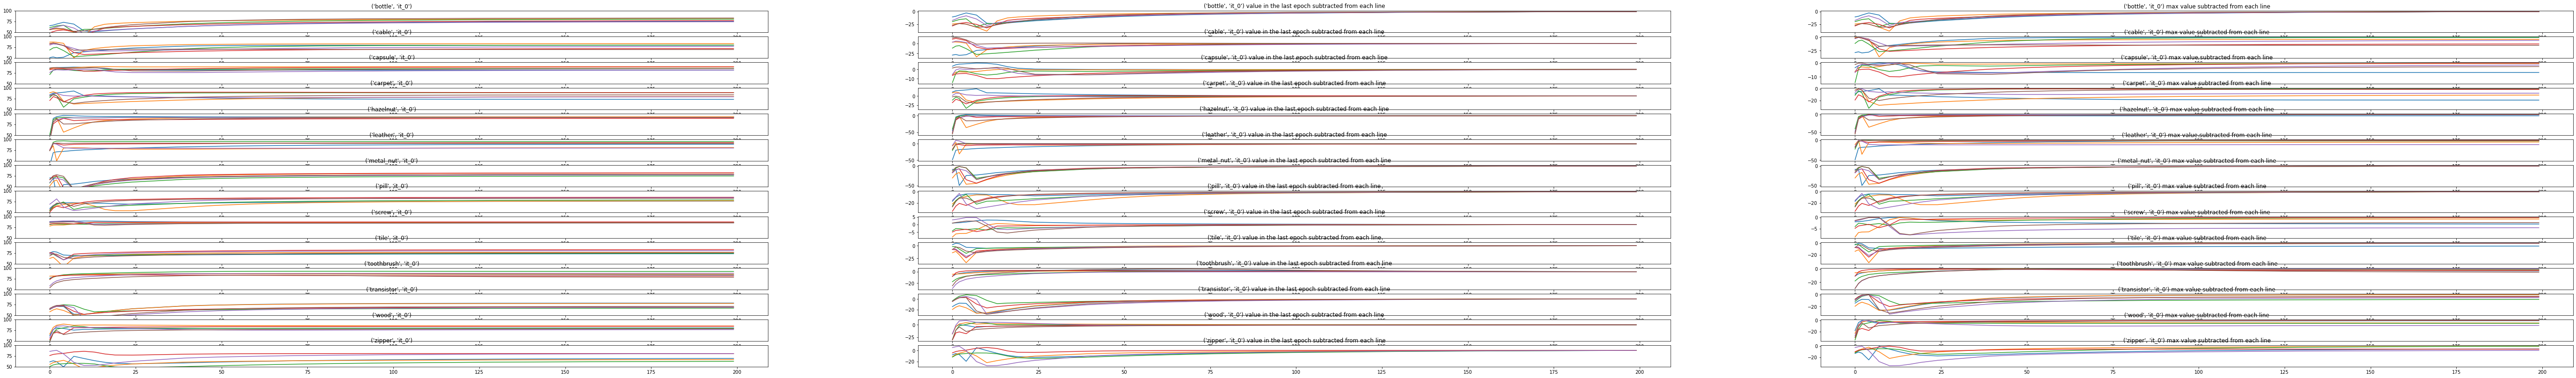

In [12]:
from matplotlib import pyplot as plt
from pandas import DataFrame


def get_epoch_series(df_: DataFrame) -> (ndarray, ndarray):
    epochs_str = sorted({col.split(".")[0] for col in df_.columns if col.startswith("epoch")})
    epochs = [int(e.split("=")[1]) for e in epochs_str]
    pixel_rocauc = df_[[es + ".pixel_roc.auc" for es in epochs_str]].T.values.ravel()
    return epochs, pixel_rocauc

map_row2ax = dict(map(reversed, enumerate(sorted(set(df.index)))))
naxs = len(map_row2ax)

fig, axs = plt.subplots(naxs, 3, figsize=(naxs * (sz := 7), 2 * sz))

for idx, dframe in df.iterrows(): 
    dframe = pd.DataFrame(dframe).T
    ax, ax_normalized, ax_normalized_max = axs[map_row2ax[idx]]
    epochs, pixel_rocauc = get_epoch_series(dframe);
    pixel_rocauc = 100 * pixel_rocauc
    
    ax.plot(epochs, pixel_rocauc);
    ax.set_title(idx);
    ax.set_ylim(50, 100)
    
    rocauc_norm_last = pixel_rocauc - pixel_rocauc[-1]
    ax_normalized.plot(epochs, rocauc_norm_last);
    ax_normalized.set_title(f"{idx} value in the last epoch subtracted from each line");
    
    rocauc_norm_max = pixel_rocauc - pixel_rocauc.max()
    ax_normalized_max.plot(epochs, rocauc_norm_max);
    ax_normalized_max.set_title(f"{idx} max value subtracted from each line");

# a more paper-quality plot

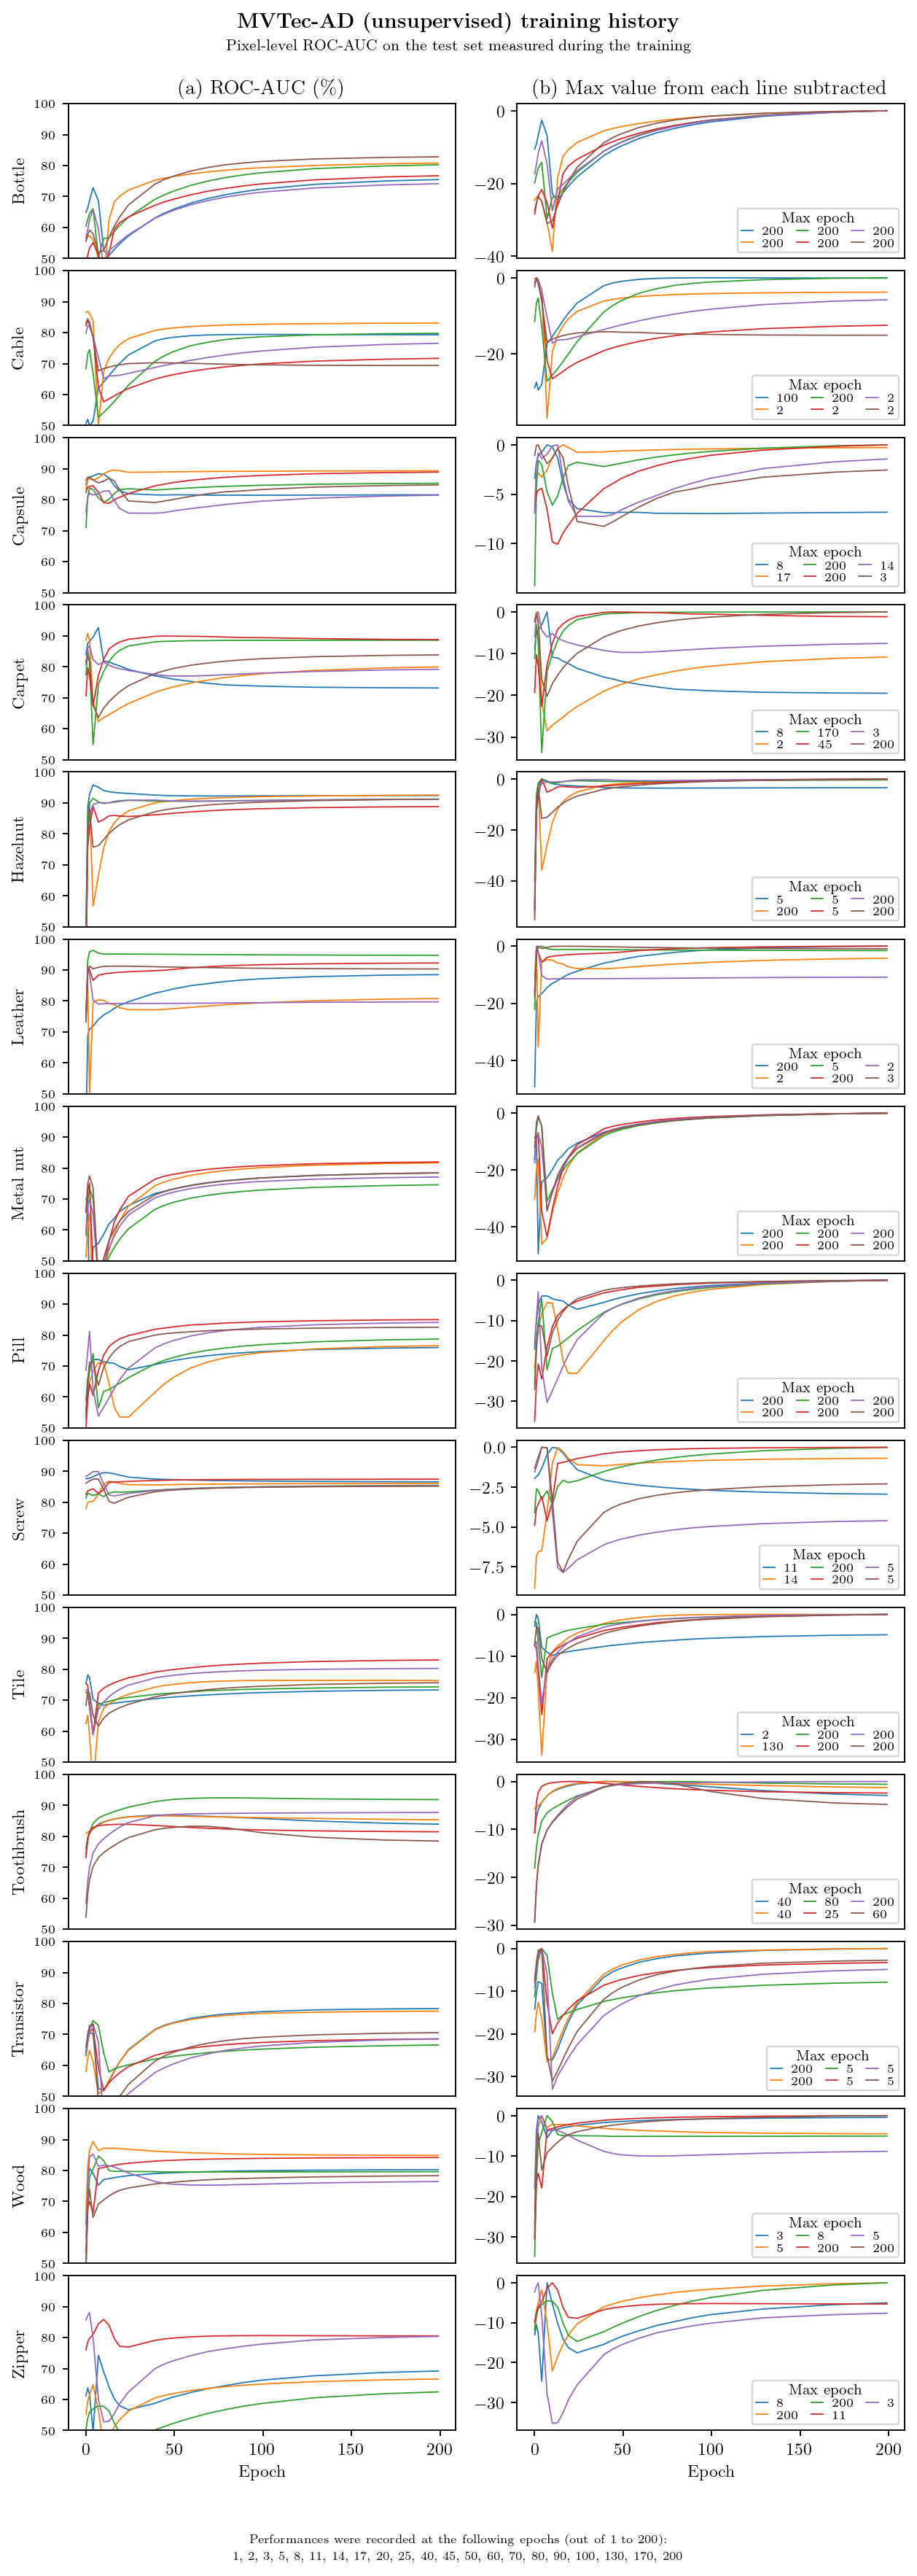

In [13]:
from matplotlib import pyplot as plt
from pandas import DataFrame
import matplotlib.ticker as ticker

# latex-ish fonts
# src: https://stackoverflow.com/a/27697390/9582881
import matplotlib
# math
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# regular text
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# this enables using latex features anywhere in the text parts, but it's slower to render
# src: https://stackoverflow.com/a/34952979/9582881
from matplotlib import rc
rc('text', usetex=True)

def format_class_label(t):
    return t.replace("_", " ").capitalize()

def get_epoch_series(df_: DataFrame) -> (ndarray, ndarray):
    epochs_str = sorted({col.split(".")[0] for col in df_.columns if col.startswith("epoch")})
    epochs = [int(e.split("=")[1]) for e in epochs_str]
    pixel_rocauc = df_[[es + ".pixel_roc.auc" for es in epochs_str]].T.values.ravel()
    return epochs, pixel_rocauc

map_row2ax = dict(map(reversed, enumerate(sorted(set(df.index)))))
naxs = len(map_row2ax)

fig, axs = plt.subplots(naxs, 2, figsize=(1.5 * (sz := 5), (.30 * naxs) * sz), dpi=170)

for idx, dframe in df.iterrows(): 
    dframe = pd.DataFrame(dframe).T
    
    ax, ax_normalized_max = axs[map_row2ax[idx]]

    epochs, pixel_rocauc = get_epoch_series(dframe);
    pixel_rocauc = 100 * pixel_rocauc
    
    class_name = format_class_label(idx[0])
    
    ax.plot(epochs, pixel_rocauc, linewidth=.75);
    ax.axes.yaxis.set_label_text(f"{class_name}")
    ax.set_ylim(50, 100)
    ax.yaxis.set_ticks(np.arange(50, 100 + 1, 10))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    ax.yaxis.set_tick_params(labelsize='x-small')
    
    rocauc_norm_max = pixel_rocauc - pixel_rocauc.max()
    max_epoch = epochs[np.argmax(rocauc_norm_max)] + 1
    ax_normalized_max.plot(epochs, rocauc_norm_max, label=f"{max_epoch}", linewidth=.75,);
    
    # src: https://stackoverflow.com/a/44620183/9582881
    # doc:https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html#matplotlib-axes-axes-legend
    ax_normalized_max.legend(
        *ax_normalized_max.get_legend_handles_labels(), 
        title="Max epoch",
        title_fontsize="small",
        fontsize="x-small",
        borderpad=.3,
        labelspacing=.1,
        columnspacing=1,
        ncol=3,
        handlelength=1,
    )
    
axs[0, 0].set_title(f"(a) ROC-AUC (\%)");
axs[0, 1].set_title(f"(b) Max value from each line subtracted");

axs[-1, 0].axes.xaxis.set_label_text(f"Epoch")
axs[-1, 1].axes.xaxis.set_label_text(f"Epoch")

for ax in axs[:-1, :].ravel():
    # ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])

fig.suptitle(r"\textbf{MVTec-AD (unsupervised) training history}" + "\n\small{Pixel-level ROC-AUC on the test set measured during the training}")

# src: https://stackoverflow.com/a/45161551/9582881
# doc: https://matplotlib.org/2.0.2/users/tight_layout_guide.html
fig.tight_layout(rect=[0, 0.025, 1, .985], h_pad=.1)

epochs = np.array(epochs) + 1
fig.text(
    x=.5, y=0,
    s=r"\scriptsize{Performances were recorded at the following epochs (out of 1 to 200):}" + "\n" + r"\scriptsize{" + f"{', '.join(map(str, epochs))}" + r"}",
    horizontalalignment="center",
    verticalalignment="bottom",
)

fig.savefig(FIGS_DIR / "mvtec-unsup-rocauc-hist.png")